# 1. Extract Multi-instance images from COCO

### 1.1 3x3 grid image with annotations

In [2]:
from PIL import Image
import os
from pycocotools.coco import COCO
import json


# Loads an image, resizes it to 256x256, scales its bounding boxes, and saves the resized image. Returns the updated annotations.
def save_image(img_info, anns,img_dir, output_dir):
    img_path = os.path.normpath(os.path.join(img_dir, img_info['file_name'])) # get the image path, normalizing the path to handle mixed separators
    # print("img_path = ",img_path)
    os.makedirs(output_dir, exist_ok=True)
    # print("output_dir = ",save_dir)


    # Check if the file exists before opening
    if not os.path.exists(img_path):
        print(f"Skipping {img_path} - File not found.")
        return  

    # load the image
    img = Image.open(img_path)

    # cal the scaling factor for width and height, for cal BB later 
    width, height = img.size
    scale_w = 256 / width
    scale_h = 256 / height

    # resize the image to 256*256
    img = img.resize((256, 256))
    img_info['width'] = 256
    img_info['height'] = 256

    save_path = os.path.join(output_dir, img_info['file_name'])
    img.save(save_path)


    # resize the BB according to the scaling factor
    new_anns = []
    for ann in anns:
        # get the BB
        x, y, w, h = ann['bbox']

        # scale the BB
        x *= scale_w
        y *= scale_h
        w *= scale_w
        h *= scale_h
        # update the BB
        ann['bbox'] = [x, y, w, h]
        ann['area'] = w*h

        new_anns.append(ann)

    return new_anns



def update_annotation_file(new_images, updated_anns, original_ann_file):
    # Load the original annotation file to retrieve the categories information
    with open(original_ann_file, 'r') as f:
        original_data = json.load(f)
    
    # Update the images and annotations fields
    original_data['images'] = new_images
    original_data['annotations'] = updated_anns
    
    # Write the updated data back to the original file
    with open(original_ann_file, 'w') as f:
        json.dump(original_data, f)



def extract_images(cat_names, img_dir, output_dir , original_ann_file):
    ## Requirements:
    # 1. Contains at least one foreground object. A foreground object must be from one of the 
    # three categories: [ ’pizza’, ’cat’, ’bus’].

    # 2. Additionally, the area of any foreground object must be larger than 200×200 = 40000 pixels. 
    # There can be multiple foreground objects in an image since we are dealing with multi-instance 
    # object localization for this homework. If there is none, that image should be discarded.

    # 3. When saving your images to disk, resize them to 256×256. Note that you would also need to 
    # scale the bounding box parameters accordingly after resizing

    cat_ids = coco.getCatIds(catNms=cat_names)

    # get all image IDs containing the above categories
    img_ids = coco.getImgIds(catIds=cat_ids)

    min_area = 40000  # 200x200


    # List to store valid images
    valid_images = []
    target_category = ["pizza", "cat", "bus"]
    updated_anns_total = []

    # loop through the images
    for img_id in img_ids:
        img_info = coco.loadImgs(img_id)[0] # get image info to save the data later

        # These are annotation IDs for objects detected in a specific image. (we are not using this)
        ann_ids = coco.getAnnIds(imgIds=img_id, iscrowd=False)

        # anns includes bounding box, category ID, and segmentation, area, imageID!!!!!!!!!!!!!!!!
        anns = coco.loadAnns(ann_ids)

        # Filter annotations: keep only those whose category is in foreground_categories 
        # and whose area is larger than min_area.
        valid_anns = []

        for ann in anns:
            # return object category name, like obj_category: umbrella, obj_category: carrot...
            obj_category = coco.loadCats(ann['category_id'])[0]['name']
            
            # if this object category is in target_category and area is larger than min_area
            if obj_category in target_category and ann['area'] > min_area:
                valid_anns.append(ann)
        
        
        # print(f"Found {len(valid_images)} images with valid annotations.") ## 3957 for training, 2062 for validation.

        # If at least one valid annotation exists, save the image and update the annotations
        if valid_anns:
            new_anns = save_image(img_info, valid_anns, img_dir, output_dir) 

            if new_anns:
                valid_images.append(img_info)
                updated_anns_total.extend(new_anns)

    return valid_images, updated_anns_total




# Set COCO dataset paths
# data_dir = os.getcwd()

#  mac users
# ann_file = os.path.join(data_dir, "annotations/instances_train2014.json") 
# image_dir = os.path.join(data_dir, "train2014/train2014")  

# windows users
ann_file_train = "./../data/annotations/instances_train2014.json"
image_dir_train = "./../HW6/train2014/train2014" 
image_dir_val = "./val2014/val2014"

ann_file_val = "./../data/annotations/instances_val2014.json"
output_dir_train = "./../data/Multi-instance_images_from_COCO(HW7)/train"
output_dir_val = "./../data/Multi-instance_images_from_COCO(HW7)/val"



# Ensure output directories exist
os.makedirs(output_dir_train, exist_ok=True)
os.makedirs(output_dir_val, exist_ok=True)


all_new_images = []
all_updated_anns = []


# Load COCO dataset
coco = COCO(ann_file_train)

valid_images, updated_anns_total= extract_images(["pizza"], img_dir = image_dir_train, output_dir = output_dir_train, original_ann_file =ann_file_train)
all_new_images.extend(valid_images)
all_updated_anns.extend(updated_anns_total)

valid_images, updated_anns_total= extract_images(["cat"], img_dir = image_dir_train, output_dir = output_dir_train, original_ann_file =ann_file_train)
all_new_images.extend(valid_images)
all_updated_anns.extend(updated_anns_total)

valid_images, updated_anns_total= extract_images(["bus"], img_dir = image_dir_train, output_dir = output_dir_train, original_ann_file =ann_file_train)
all_new_images.extend(valid_images)
all_updated_anns.extend(updated_anns_total)

update_annotation_file(all_new_images, all_updated_anns, ann_file_train)


# Load COCO dataset
coco = COCO(ann_file_val)

valid_images, updated_anns_total= extract_images(["pizza"], img_dir = image_dir_val, output_dir = output_dir_val, original_ann_file =ann_file_val)
all_new_images.extend(valid_images)
all_updated_anns.extend(updated_anns_total)

valid_images, updated_anns_total= extract_images(["cat"], img_dir = image_dir_val, output_dir = output_dir_val, original_ann_file =ann_file_val)
all_new_images.extend(valid_images)
all_updated_anns.extend(updated_anns_total)

valid_images, updated_anns_total= extract_images(["bus"], img_dir = image_dir_val, output_dir = output_dir_val, original_ann_file =ann_file_val)
all_new_images.extend(valid_images)
all_updated_anns.extend(updated_anns_total)

update_annotation_file(all_new_images, all_updated_anns, ann_file_val)


loading annotations into memory...
Done (t=10.54s)
creating index...
index created!
loading annotations into memory...
Done (t=4.74s)
creating index...
index created!


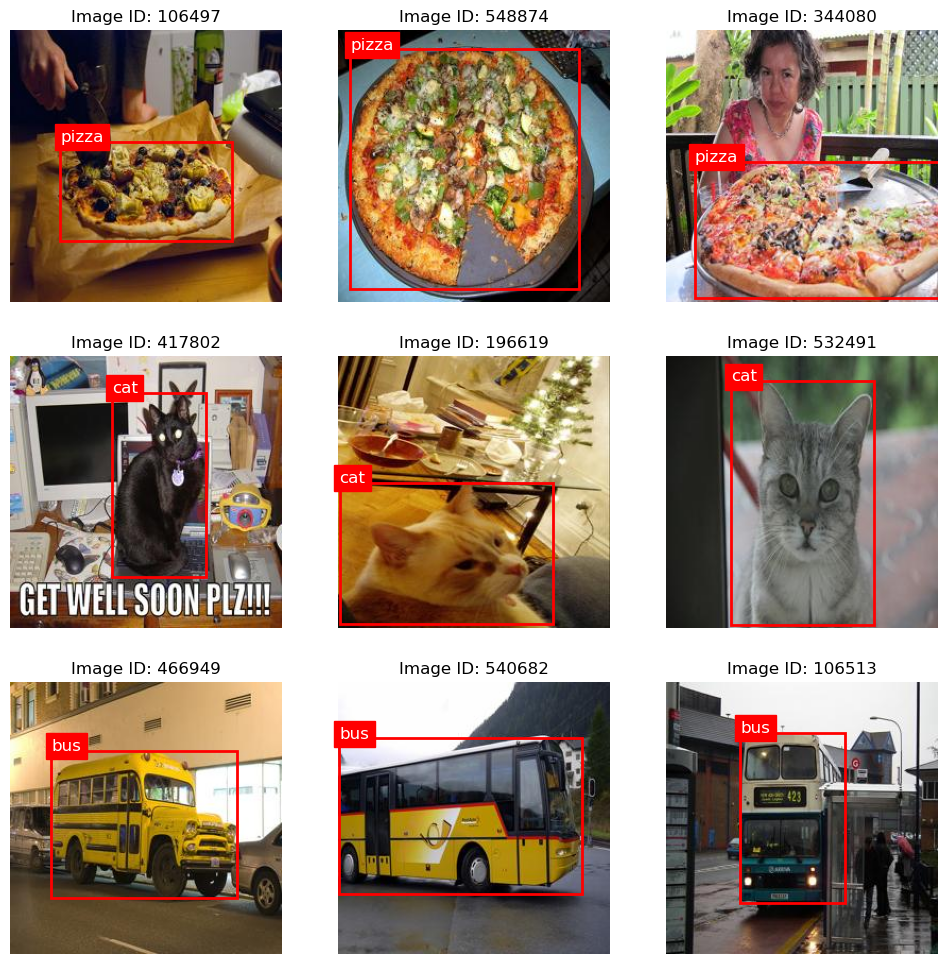

In [13]:
import os
import json
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

def visualize_images(annotation_file, image_dir):
    # Load the updated annotation file 
    with open(annotation_file, 'r') as f:
        data = json.load(f)
    
    # Build mappings for images and catID2name
    images = {img["id"]: img for img in data["images"]}
    cat_id_to_name = {cat["id"]: cat["name"] for cat in data["categories"]}
    # print("images\n",images) ## {466949: {'license': 1, 'file_name': 'COCO_train2014_000000466949.jpg', 'coco_url': 'http://images.cocodataset.org/train2014/COCO_train2014_000000466949.jpg', 'height': ....
    # print("cat_id_to_name\n",cat_id_to_name) ## {1: 'person', 2: 'bicycle', 3: 'car'...

    
    target_categories = ["pizza", "cat", "bus"]
    # get their ID
    cat_to_img_ids = {cat: set() for cat in target_categories} # set for avoiding duplicate ## cat_to_img_ids = {'pizza': set(), 'cat': set(), 'bus': set()}
    for ann in data["annotations"]:
        cat_name = cat_id_to_name[ann["category_id"]]
        if cat_name in target_categories:
            cat_to_img_ids[cat_name].add(ann["image_id"])
    
    # Select 3 images per category 
    selected_ids = []
    for cat in target_categories:
        count = 0
        # print("\n\n",cat)
        for img_id in cat_to_img_ids[cat]:
            # print("check",img_id)
            if img_id not in selected_ids:
                selected_ids.append(img_id)
                # print("add",img_id)
                count += 1
            if count == 3:
                break

    # print(selected_ids)
 

    # plot the 3x3 graph
    fig, axs = plt.subplots(3, 3, figsize=(12, 12))
    axs = axs.flatten()
    for i, img_id in enumerate(selected_ids):
        img_info = images[img_id]
        img_path = os.path.join(image_dir, img_info["file_name"])
        
        # Open the image using PIL
        img = Image.open(img_path)

        axs[i].imshow(img)
        axs[i].axis("off")
        
        # For each annotation in the image, add a rectangle patch and label it with the category name
        for ann in data["annotations"]:
            if ann["image_id"] == img_id:
                bbox = ann["bbox"] # Format: [x, y, width, height]

                # Create a rectangle patch for the bounding box
                rect = Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], fill=False, edgecolor='red', linewidth=2)
                axs[i].add_patch(rect)

                # Add the category name label at the top-left corner of the bounding box
                cat_name = cat_id_to_name[ann["category_id"]]
                axs[i].text(bbox[0], bbox[1], cat_name,fontsize=12, color='white', backgroundcolor='red')
        
        axs[i].set_title(f"Image ID: {img_id}")
    
    plt.show()



updated_annotation_file = "./../data/annotations/instances_train2014.json"
resized_image_dir = "./../data/Multi-instance_images_from_COCO(HW7)/train"

visualize_images(updated_annotation_file, resized_image_dir)


# 2. Dataloader

### 2.1 Code block showing all parameters for yolo vector are generated

### 2.2 explanationg showing all parameters for yolo vector are generated

# 3. Training

### 3.1 Code block showing how yolo tensor is built

### 3.2 explanation of building how yolo tensor is built

### 3.3 BCE, CE, MSE loss curves

# 4. Evaluation

### 4.1 Code block translate yolo tensor to BB pred and class label

### 4.2 Explanation translate yolo tensor to BB pred and class label

### 4.3 24 images

# 5. Bonus IoU loss with DIoU

### 5.1 BCE, CE, DIoU loss curves

### 5.2 24 images